In [103]:
from typing import Any
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import (base, linear_model, metrics,
                     model_selection, pipeline, tree)
import xgboost as xgb
from yellowbrick import regressor

# Classes

In [43]:
class TweakDirtyTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, y_col=None):
        self.y_col = y_col
        self.y_val = None
        
    def transform(self, X):
        return tweak_dirty(X)
    
    def fit(self, X, y=None):
        return self

### Helper Functions

In [4]:
def to_denver_time(df_:pd.DataFrame, time_col:str, tz_col:str) -> pd.DataFrame:
    """Convert datetime column to regional denver time"""
    return (
        df_
        .assign(**{tz_col: df_[tz_col].replace('MDT', 'MST7MDT')})
        .groupby(tz_col)
        [time_col]
        .transform( lambda series: pd.to_datetime(series)
                    .dt.tz_localize(series.name, ambiguous=True)
                    .dt.tz_convert('America/Denver')
                    )
    )

In [66]:
def tweak_river(df_: pd.DataFrame) -> pd.DataFrame:
    """Preprocess the data for regression"""
    return (
        df_
        .assign(datetime=to_denver_time(df_, "datetime", "tz_cd"))
        .rename(columns={"144166_00060": "cfs",
                         "144167_00065": "gage_height"})
        .loc[:, ['datetime', "cfs", "gage_height"]]
    )

In [67]:
def tweak_temp(df_: pd.DataFrame) -> pd.DataFrame:
    """Take the data for regression"""
    return (df_
            .assign(DATE=pd.to_datetime(df_["DATE"]).dt.tz_localize('America/Denver', ambiguous=False)
                    )
            .loc[:, ["DATE", "PRCP", "TMIN", "TMAX", "TOBS"]]
            )

In [7]:
def cyclic_encode(adf, col, x_suffix="_x", y_suffix="_y"):
    return (adf
            .assign(**{f"{col}{x_suffix}":
            np.sin((2*np.pi*adf[col]) / (adf[col].nunique())),
    f"{col}{y_suffix}":
    np.cos((2*np.pi*adf[col]) /(adf[col].nunique()))
})
            )

In [131]:
def tweak_dirty(adf: pd.DataFrame) -> pd.DataFrame:
    return (adf
            .assign(dow=adf["DATE"].dt.day_of_week,
                    day=adf["DATE"].dt.day,
                    month=adf["DATE"].dt.month,
                    doy=adf["DATE"].dt.day_of_year
                    )
            .query("month <= 5") # limit to spring
            .pipe(cyclic_encode, col="dow")
            .pipe(cyclic_encode, col="day")
            .pipe(cyclic_encode, col="month")
            .pipe(cyclic_encode, col="doy")
            .loc[:, ["cfs", "gage_height", "PRCP", "TMIN", "TMAX", "TOBS",
                     "dow", "day", "month", "doy", "dow_x", "dow_y", "day_x", 
                     "day_y", "month_x", "month_y", "doy_x", "doy_y"]]
        .astype({"PRCP": float,
                 "TMIN": float,
                 "TMAX": float,
                 "TOBS": float,
                 "gage_height": float,
                 "cfs": float})
    )

## Load datasets

In [9]:
url: str = "https://github.com/mattharrison/datasets/raw/master/data/dirtydevil.txt"
url_temp: str = "https://github.com/mattharrison/datasets/raw/master/data/hanksville.csv"

In [10]:
raw_data: pd.DataFrame = pd.read_csv(url, skiprows=lambda num:num<34 or num ==35,
                                     sep='\t', dtype_backend='pyarrow')

In [11]:
raw_temp_data: pd.DataFrame = pd.read_csv(url_temp, dtype_backend="pyarrow", engine="pyarrow")

In [12]:
raw_data.tz_cd.value_counts()

tz_cd
MDT    341843
MST    197462
Name: count, dtype: int64[pyarrow]

In [13]:
raw_temp_data

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,WT06,WT11
0,USW00023170,"HANKSVILLE, UT US",38.37497,-110.71906,1304.5,2000-01-01,<NA>,<NA>,0.02,0.0,0.0,43,21,28,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,USW00023170,"HANKSVILLE, UT US",38.37497,-110.71906,1304.5,2000-01-02,<NA>,<NA>,0.03,0.0,0.0,39,24,24,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,USW00023170,"HANKSVILLE, UT US",38.37497,-110.71906,1304.5,2000-01-03,<NA>,<NA>,0.00,0.0,0.0,39,7,18,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,USW00023170,"HANKSVILLE, UT US",38.37497,-110.71906,1304.5,2000-01-04,<NA>,<NA>,0.00,0.0,0.0,39,5,25,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,USW00023170,"HANKSVILLE, UT US",38.37497,-110.71906,1304.5,2000-01-05,<NA>,<NA>,0.00,0.0,0.0,44,10,22,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6843,USW00023170,"HANKSVILLE, UT US",38.37497,-110.71906,1304.5,2020-09-20,<NA>,<NA>,0.00,0.0,0.0,92,46,83,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6844,USW00023170,"HANKSVILLE, UT US",38.37497,-110.71906,1304.5,2020-09-21,<NA>,<NA>,0.00,0.0,0.0,92,47,84,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6845,USW00023170,"HANKSVILLE, UT US",38.37497,-110.71906,1304.5,2020-09-22,<NA>,<NA>,0.00,0.0,0.0,84,54,77,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6846,USW00023170,"HANKSVILLE, UT US",38.37497,-110.71906,1304.5,2020-09-23,<NA>,<NA>,0.00,0.0,0.0,91,47,87,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


### Tweak Dataset

In [69]:
river_df: pd.DataFrame = tweak_river(raw_data)

In [70]:
river_df

,datetime,cfs,gage_height
0,2001-05-07 01:00:00-06:00,71.00,<NA>
1,2001-05-07 01:15:00-06:00,71.00,<NA>
2,2001-05-07 01:30:00-06:00,71.00,<NA>
3,2001-05-07 01:45:00-06:00,70.00,<NA>
4,2001-05-07 02:00:00-06:00,70.00,<NA>
...,...,...,...
539300,2020-09-28 08:30:00-06:00,9.53,6.16
539301,2020-09-28 08:45:00-06:00,9.20,6.15
539302,2020-09-28 09:00:00-06:00,9.20,6.15
539303,2020-09-28 09:15:00-06:00,9.20,6.15


In [71]:
temp_df: pd.DataFrame = tweak_temp(raw_temp_data)

In [72]:
temp_df

,DATE,PRCP,TMIN,TMAX,TOBS
0,2000-01-01 00:00:00-07:00,0.02,21,43,28
1,2000-01-02 00:00:00-07:00,0.03,24,39,24
2,2000-01-03 00:00:00-07:00,0.00,7,39,18
3,2000-01-04 00:00:00-07:00,0.00,5,39,25
4,2000-01-05 00:00:00-07:00,0.00,10,44,22
...,...,...,...,...,...
6843,2020-09-20 00:00:00-06:00,0.00,46,92,83
6844,2020-09-21 00:00:00-06:00,0.00,47,92,84
6845,2020-09-22 00:00:00-06:00,0.00,54,84,77
6846,2020-09-23 00:00:00-06:00,0.00,47,91,87


In [73]:
day_river_df: pd.DataFrame = (river_df
                              .groupby(pd.Grouper(key='datetime', freq='D'))
                              .median(numeric_only=True)
                              .merge(temp_df, left_index=True, right_on="DATE", how="inner",
                                     validate="1:1")
                              )

In [74]:
day_river_df

,cfs,gage_height,DATE,PRCP,TMIN,TMAX,TOBS
492,71.50,<NA>,2001-05-07 00:00:00-06:00,0.0,41,82,55
493,69.00,<NA>,2001-05-08 00:00:00-06:00,0.0,43,85,58
494,63.50,<NA>,2001-05-09 00:00:00-06:00,0.0,36,92,64
495,55.00,<NA>,2001-05-10 00:00:00-06:00,0.0,50,92,67
496,55.00,<NA>,2001-05-11 00:00:00-06:00,0.0,46,87,60
...,...,...,...,...,...,...,...
6843,6.83,6.07,2020-09-20 00:00:00-06:00,0.0,46,92,83
6844,6.83,6.07,2020-09-21 00:00:00-06:00,0.0,47,92,84
6845,7.39,6.09,2020-09-22 00:00:00-06:00,0.0,54,84,77
6846,7.97,6.11,2020-09-23 00:00:00-06:00,0.0,47,91,87


# EDA

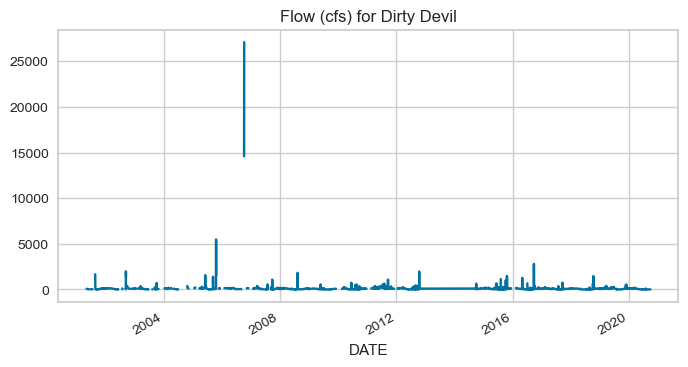

In [75]:
fig, ax = plt.subplots(figsize=(8, 4))
(
    day_river_df
    .set_index("DATE")
    .cfs
    .plot(ax=ax, title="Flow (cfs) for Dirty Devil")
)
plt.show()

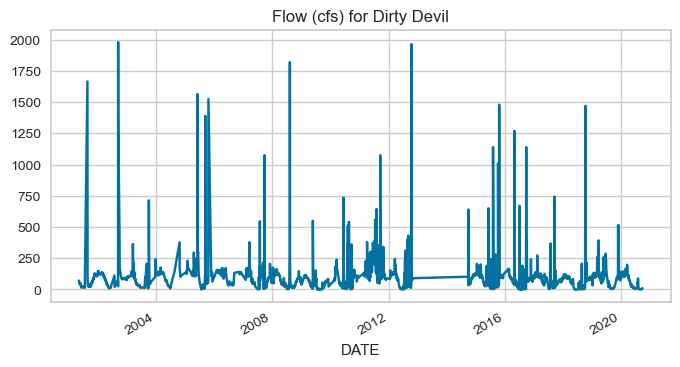

In [76]:
fig, ax = plt.subplots(figsize=(8, 4))
(day_river_df
.set_index("DATE")
 .query("cfs < 2000")
 .cfs
 .plot(ax=ax, title="Flow (cfs) for Dirty Devil")
 )
plt.show()

# Dataset for modeling

In [132]:
pl: pipeline = pipeline.Pipeline([("tweak", TweakDirtyTransformer())])

In [133]:
X: pd.DataFrame = day_river_df

In [134]:
X

,cfs,gage_height,DATE,PRCP,TMIN,TMAX,TOBS
492,71.50,<NA>,2001-05-07 00:00:00-06:00,0.0,41,82,55
493,69.00,<NA>,2001-05-08 00:00:00-06:00,0.0,43,85,58
494,63.50,<NA>,2001-05-09 00:00:00-06:00,0.0,36,92,64
495,55.00,<NA>,2001-05-10 00:00:00-06:00,0.0,50,92,67
496,55.00,<NA>,2001-05-11 00:00:00-06:00,0.0,46,87,60
...,...,...,...,...,...,...,...
6843,6.83,6.07,2020-09-20 00:00:00-06:00,0.0,46,92,83
6844,6.83,6.07,2020-09-21 00:00:00-06:00,0.0,47,92,84
6845,7.39,6.09,2020-09-22 00:00:00-06:00,0.0,54,84,77
6846,7.97,6.11,2020-09-23 00:00:00-06:00,0.0,47,91,87


In [135]:
y: pd.Series = day_river_df["cfs"].shift(-7)

In [136]:
y

492     45.0
493     55.0
494     51.5
495     53.0
496     49.0
        ... 
6843    <NA>
6844    <NA>
6845    <NA>
6846    <NA>
6847    <NA>
Name: cfs, Length: 6356, dtype: double[pyarrow]

*drop missing y values*

In [137]:
y: pd.Series = y[~y.isna()]

In [138]:
X: pd.DataFrame = X.loc[y.index]

In [139]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42)

In [140]:
X_train

,cfs,gage_height,DATE,PRCP,TMIN,TMAX,TOBS
3307,97.8,3.92,2009-02-17 00:00:00-07:00,0.00,20,54,38
5460,78.5,5.31,2016-12-05 00:00:00-07:00,0.00,14,49,43
557,<NA>,<NA>,2001-07-11 00:00:00-06:00,0.00,60,93,72
6100,7.7,5.855,2018-09-08 00:00:00-06:00,0.00,50,94,<NA>
6453,3.76,5.92,2019-08-27 00:00:00-06:00,0.00,49,102,97
...,...,...,...,...,...,...,...
6624,101.0,6.76,2020-02-14 00:00:00-07:00,0.00,14,59,46
1481,128.0,<NA>,2004-01-21 00:00:00-07:00,0.00,13,44,21
5286,13.1,4.96,2016-06-14 00:00:00-06:00,0.00,47,92,91
5970,38.1,6.41,2018-05-01 00:00:00-06:00,0.23,46,65,56


In [141]:
X_train: Any = pl.fit_transform(X_train)

In [142]:
X_test: Any = pl.transform(X_test)

*refilter y*

In [143]:
y_train: pd.Series = y_train.loc[X_train.index]
y_test: pd.Series = y_test.loc[X_test.index]

In [144]:
y_train

3307    107.0
2595    186.0
5937     56.1
3034     61.9
2586    114.0
        ...  
4466     80.9
2232    127.0
6624    131.0
1481    112.0
5970     38.4
Name: cfs, Length: 1558, dtype: double[pyarrow]

In [145]:
X: pd.DataFrame = pd.concat([X_train, X_test], axis="index")
y: pd.Series = pd.concat([y_train, y_test], axis="index")

### Linear Regression

In [146]:
lr = linear_model.LinearRegression()

In [147]:
lr.fit(X_train.fillna(0), y_train)

LinearRegression()

In [148]:
lr.score(X_test.fillna(0), y_test)

0.19320188521862858

### Decision Tree

In [149]:
dt = tree.DecisionTreeRegressor(max_depth=3)

In [150]:
dt.fit(X_train.fillna(0), y_train)

DecisionTreeRegressor(max_depth=3)

In [151]:
dt.score(X_test.fillna(0), y_test)

-1.0764198713366064

### XG Model

In [152]:
xg = xgb.XGBRegressor(early_stopping_rounds=10)

In [153]:
evaluation = [(X_train, y_train), (X_test, y_test)]

In [154]:
xg.fit(X_train, y_train, eval_set=evaluation)

[0]	validation_0-rmse:94.22152	validation_1-rmse:83.68270
[1]	validation_0-rmse:73.30294	validation_1-rmse:66.67974
[2]	validation_0-rmse:58.75377	validation_1-rmse:55.59619
[3]	validation_0-rmse:48.54623	validation_1-rmse:49.31067
[4]	validation_0-rmse:41.19431	validation_1-rmse:47.96032
[5]	validation_0-rmse:35.71972	validation_1-rmse:48.39448
[6]	validation_0-rmse:31.85567	validation_1-rmse:48.31734
[7]	validation_0-rmse:29.24241	validation_1-rmse:49.01986
[8]	validation_0-rmse:27.29770	validation_1-rmse:48.73836
[9]	validation_0-rmse:26.03929	validation_1-rmse:49.11177
[10]	validation_0-rmse:24.83452	validation_1-rmse:49.59899
[11]	validation_0-rmse:23.67011	validation_1-rmse:49.81794
[12]	validation_0-rmse:22.92221	validation_1-rmse:49.88742
[13]	validation_0-rmse:22.48505	validation_1-rmse:50.00398


/Users/everreyesruiz/mambaforge/envs/ml/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/everreyesruiz/mambaforge/envs/ml/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/everreyesruiz/mambaforge/envs/ml/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/everreyesruiz/mambaforge/envs/ml/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Cat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [155]:
xg.fit(X_train, y_train, eval_set=evaluation)

[0]	validation_0-rmse:94.22152	validation_1-rmse:83.68270
[1]	validation_0-rmse:73.30294	validation_1-rmse:66.67974
[2]	validation_0-rmse:58.75377	validation_1-rmse:55.59619
[3]	validation_0-rmse:48.54623	validation_1-rmse:49.31067
[4]	validation_0-rmse:41.19431	validation_1-rmse:47.96032
[5]	validation_0-rmse:35.71972	validation_1-rmse:48.39448
[6]	validation_0-rmse:31.85567	validation_1-rmse:48.31734
[7]	validation_0-rmse:29.24241	validation_1-rmse:49.01986
[8]	validation_0-rmse:27.29770	validation_1-rmse:48.73836
[9]	validation_0-rmse:26.03929	validation_1-rmse:49.11177
[10]	validation_0-rmse:24.83452	validation_1-rmse:49.59899
[11]	validation_0-rmse:23.67011	validation_1-rmse:49.81794
[12]	validation_0-rmse:22.92221	validation_1-rmse:49.88742
[13]	validation_0-rmse:22.48505	validation_1-rmse:50.00398
[14]	validation_0-rmse:21.97194	validation_1-rmse:50.14763


/Users/everreyesruiz/mambaforge/envs/ml/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/everreyesruiz/mambaforge/envs/ml/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/everreyesruiz/mambaforge/envs/ml/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/everreyesruiz/mambaforge/envs/ml/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Cat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [156]:
xg.score(X_test, y_test)

/Users/everreyesruiz/mambaforge/envs/ml/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/everreyesruiz/mambaforge/envs/ml/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/everreyesruiz/mambaforge/envs/ml/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/everreyesruiz/mambaforge/envs/ml/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Cat

0.1831625155577825

# Visualization